In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [67]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [3]:
tor_2019 = read_merged('tornados', 2019)

In [4]:
tor_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58403 entries, 0 to 58402
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            58403 non-null  int64  
 1   DATE                  58403 non-null  object 
 2   LAT_mean              58403 non-null  float64
 3   LON_mean              58403 non-null  float64
 4   AVGDV_max             58403 non-null  int64  
 5   LLDV_max              58403 non-null  int64  
 6   MXDV_max              58403 non-null  int64  
 7   MXDV_HEIGHT_max       58403 non-null  int64  
 8   DEPTH_max             58403 non-null  float64
 9   MAX_SHEAR_max         58403 non-null  int64  
 10  MAX_SHEAR_HEIGHT_max  58403 non-null  float64
 11  county                58403 non-null  object 
 12  state                 58403 non-null  object 
 13  power_outage          58403 non-null  bool   
dtypes: bool(1), float64(4), int64(6), object(3)
memory usage: 5.8+ MB


In [5]:
#del light_2019['#ZDAY']


In [6]:
del tor_2019['Unnamed: 0']
tor_2019['DATE'] = pd.to_datetime(tor_2019['DATE'])
tor_2019['Month'] = tor_2019['DATE'].dt.month

In [7]:
tor_2019.columns

Index(['DATE', 'LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max',
       'county', 'state', 'power_outage', 'Month'],
      dtype='object')

In [8]:
tor_2019['power_outage'].value_counts(normalize=True)

False    0.957297
True     0.042703
Name: power_outage, dtype: float64

### Let's try XGBOOST

In [9]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer


In [11]:
tor_train, tor_test = train_test_split(tor_2019.copy(), shuffle=True, test_size=0.2, stratify=tor_2019.power_outage)

In [12]:
xgb_clas1 = xgboost.XGBClassifier(learning_rate=.1,
                                   max_depth=3,
                                   n_estimators=200, objective='binary:logistic')

In [13]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max', 'Month']

In [14]:
xgb_clas1.fit(tor_train[features], tor_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
prec = precision_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.13634085213032582
recall:  0.6522781774580336


In [35]:
pred = xgb_clas1.predict(light_train[features])
acc, prec, recall = accuracy_score(pred, light_train.power_outage), precision_score(pred, light_train.power_outage), recall_score(pred, light_train.power_outage)

In [19]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 20,  1),
    'n_estimators': range(100, 480, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)
grid_search.fit(tor_train[features], tor_train['power_outage'])

In [20]:
grid_search.fit(tor_train[features], tor_train['power_outage'])

Fitting 5 folds for each of 760 candidates, totalling 3800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': range(1, 20),
                         'n_estimators': range(100, 480, 40)},
             scoring='f1', verbose=True)

In [21]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [22]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 1, 100): 0.0,
 (0.01, 1, 140): 0.0,
 (0.01, 1, 180): 0.0,
 (0.01, 1, 220): 0.0,
 (0.01, 1, 260): 0.0,
 (0.01, 1, 300): 0.0,
 (0.01, 1, 340): 0.0,
 (0.01, 1, 380): 0.0,
 (0.01, 1, 420): 0.0,
 (0.01, 1, 460): 0.0,
 (0.01, 2, 100): 0.0,
 (0.01, 2, 140): 0.0,
 (0.01, 2, 180): 0.0,
 (0.01, 2, 220): 0.0,
 (0.01, 2, 260): 0.0,
 (0.01, 2, 300): 0.0,
 (0.01, 2, 340): 0.0,
 (0.01, 2, 380): 0.0,
 (0.01, 2, 420): 0.0,
 (0.01, 2, 460): 0.0,
 (0.01, 3, 100): 0.0,
 (0.01, 3, 140): 0.0,
 (0.01, 3, 180): 0.0,
 (0.01, 3, 220): 0.0,
 (0.01, 3, 260): 0.001,
 (0.01, 3, 300): 0.001,
 (0.01, 3, 340): 0.001,
 (0.01, 3, 380): 0.004889975550122249,
 (0.01, 3, 420): 0.005853658536585366,
 (0.01, 3, 460): 0.005853658536585366,
 (0.01, 4, 100): 0.0,
 (0.01, 4, 140): 0.004980087095693602,
 (0.01, 4, 180): 0.007942976992327426,
 (0.01, 4, 220): 0.007940618140506209,
 (0.01, 4, 260): 0.015640002385004285,
 (0.01, 4, 300): 0.02536535670282013,
 (0.01, 4, 340): 0.032059066638673306,
 (0.01, 4, 380): 0.033017920

In [23]:
best_param = pars[np.argmax(scores)]

In [24]:
best_param

(0.03, 17, 180)

In [25]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=17,
    n_estimators=180) 

In [26]:
best_model.fit(tor_train[features], tor_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
prec = precision_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6902255639097744
recall:  0.8883870967741936


In [145]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6274321524233082
recall:  0.8734039185338914


In [29]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 4.652883052825928,
 'LON_mean': 4.585465431213379,
 'AVGDV_max': 1.047420859336853,
 'LLDV_max': 1.0794237852096558,
 'MXDV_max': 1.0022969245910645,
 'MXDV_HEIGHT_max': 0.9618530869483948,
 'DEPTH_max': 1.1762429475784302,
 'MAX_SHEAR_max': 1.2311267852783203,
 'MAX_SHEAR_HEIGHT_max': 1.1681315898895264,
 'Month': 8.831318855285645}

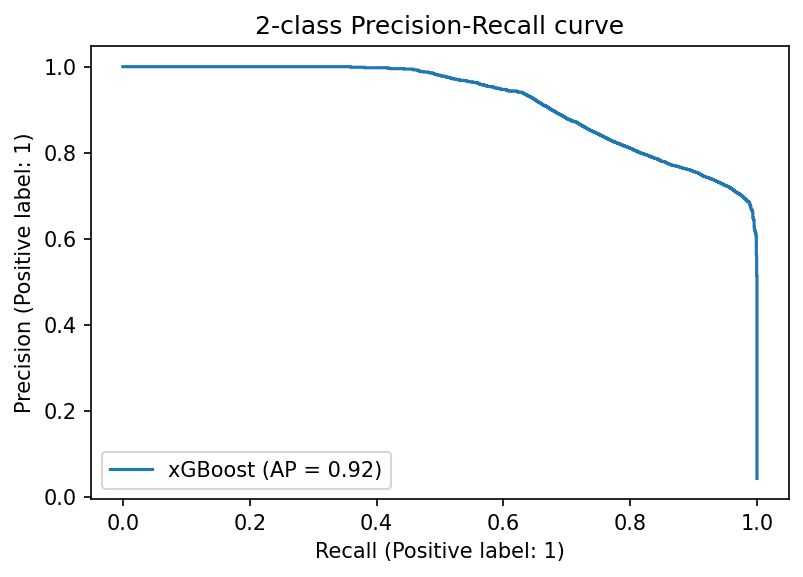

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_train[features], tor_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Work on the Balanced Dataset

In [48]:
outage = tor_train[tor_train['power_outage']==True]
no_outage = tor_train[tor_train['power_outage']==False]
no_outage= no_outage.sample(n=8*len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [35]:
balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7980 entries, 25142 to 53330
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATE                  7980 non-null   datetime64[ns]
 1   LAT_mean              7980 non-null   float64       
 2   LON_mean              7980 non-null   float64       
 3   AVGDV_max             7980 non-null   int64         
 4   LLDV_max              7980 non-null   int64         
 5   MXDV_max              7980 non-null   int64         
 6   MXDV_HEIGHT_max       7980 non-null   int64         
 7   DEPTH_max             7980 non-null   float64       
 8   MAX_SHEAR_max         7980 non-null   int64         
 9   MAX_SHEAR_HEIGHT_max  7980 non-null   float64       
 10  county                7980 non-null   object        
 11  state                 7980 non-null   object        
 12  power_outage          7980 non-null   bool          
 13  Month        

In [36]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (8, 20,  2),
    'n_estimators': range(100, 500, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)

In [37]:
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3],
                         'max_depth': range(8, 20, 2),
                         'n_estimators': range(100, 500, 40)},
             scoring='f1', verbose=True)

In [38]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [39]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 8, 100): 0.725908279934892,
 (0.01, 8, 140): 0.7461887392570804,
 (0.01, 8, 180): 0.7668915469796136,
 (0.01, 8, 220): 0.7717177004733282,
 (0.01, 8, 260): 0.7785149734368395,
 (0.01, 8, 300): 0.7822396935715996,
 (0.01, 8, 340): 0.7821008642326378,
 (0.01, 8, 380): 0.7827752328053984,
 (0.01, 8, 420): 0.7809322768885727,
 (0.01, 8, 460): 0.7815653129483878,
 (0.01, 10, 100): 0.7403129571907667,
 (0.01, 10, 140): 0.765148313856292,
 (0.01, 10, 180): 0.7782445990984772,
 (0.01, 10, 220): 0.7804861481484112,
 (0.01, 10, 260): 0.7825723959531389,
 (0.01, 10, 300): 0.7829051248569482,
 (0.01, 10, 340): 0.7824670502949119,
 (0.01, 10, 380): 0.7810053006987102,
 (0.01, 10, 420): 0.7814521471909465,
 (0.01, 10, 460): 0.7815415338235272,
 (0.01, 12, 100): 0.7350170018472596,
 (0.01, 12, 140): 0.7608502334150724,
 (0.01, 12, 180): 0.7676318924780636,
 (0.01, 12, 220): 0.7726478780856658,
 (0.01, 12, 260): 0.7743512923411969,
 (0.01, 12, 300): 0.7776178624737564,
 (0.01, 12, 340): 0.7759

In [41]:
best_param = pars[np.argmax(scores)]
best_param

(0.03, 10, 100)

In [49]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=10,
    n_estimators=100) 

In [50]:
best_model.fit(balanced[features], balanced['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
prec = precision_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(best_model.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.7363408521303259
recall:  0.5248302965344765


In [53]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 12.50930404663086,
 'LON_mean': 11.72362232208252,
 'AVGDV_max': 2.1541082859039307,
 'LLDV_max': 1.9926567077636719,
 'MXDV_max': 1.8931102752685547,
 'MXDV_HEIGHT_max': 1.8448606729507446,
 'DEPTH_max': 2.5698893070220947,
 'MAX_SHEAR_max': 2.258812189102173,
 'MAX_SHEAR_HEIGHT_max': 1.939786672592163,
 'Month': 16.8094482421875}

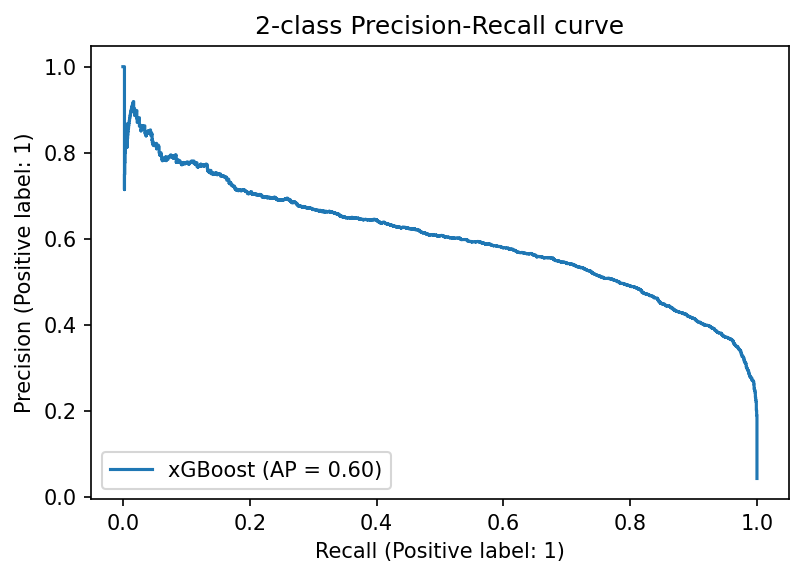

In [54]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_train[features], tor_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Using multiple years of tornados

In [2]:
# Download them
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [3]:
tornados = [read_merged("tornados", year) for year in range(2015, 2024)]

In [5]:
data = pd.concat(tornados)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346371 entries, 0 to 39465
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            346371 non-null  int64  
 1   DATE                  346371 non-null  object 
 2   LAT_mean              346371 non-null  float64
 3   LON_mean              346371 non-null  float64
 4   AVGDV_max             346371 non-null  int64  
 5   LLDV_max              346371 non-null  int64  
 6   MXDV_max              346371 non-null  int64  
 7   MXDV_HEIGHT_max       346371 non-null  int64  
 8   DEPTH_max             346371 non-null  float64
 9   MAX_SHEAR_max         346371 non-null  int64  
 10  MAX_SHEAR_HEIGHT_max  346371 non-null  float64
 11  county                346371 non-null  object 
 12  state                 346371 non-null  object 
 13  Month                 129786 non-null  object 
 14  power_outage          346371 non-null  bool   
 15  E

In [7]:
data.sample(100)

,Unnamed: 0,DATE,LAT_mean,LON_mean,AVGDV_max,LLDV_max,MXDV_max,MXDV_HEIGHT_max,DEPTH_max,MAX_SHEAR_max,MAX_SHEAR_HEIGHT_max,county,state,Month,power_outage,Event Month
10698,10698,2021-05-11,32.70594,-96.413492,60,89,101,30,26.3,52,29.8,Kaufman County,Texas,NaN,False,NaN
18619,18619,2021-07-10,39.17796,-94.087560,35,29,83,16,11.1,35,15.7,Ray County,Missouri,July,True,NaN
66369,66369,2020-12-24,35.62726,-77.993900,64,95,98,5,8.7,38,5.4,Wilson County,North Carolina,December,False,NaN
9832,9832,2020-02-07,60.76219,-152.571360,34,52,52,3,5.4,23,2.8,Kenai Peninsula Borough,Alaska,February,False,NaN
33800,33800,2021-10-05,35.54371,-90.414920,60,70,93,12,9.3,34,11.9,Poinsett County,Arkansas,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22130,22130,2015-12-13,30.20638,-95.531480,42,57,63,14,11.4,23,13.6,Montgomery County,Texas,NaN,False,NaN
18308,18308,2018-08-21,40.38416,-111.969960,64,86,87,10,7.3,39,2.7,Utah County,Utah,NaN,False,NaN
5339,5339,2021-03-27,35.98540,-80.815190,29,75,75,5,17.2,30,5.1,Iredell County,North Carolina,NaN,False,NaN
19360,19360,2020-04-13,39.58430,-76.434590,43,124,124,4,19.2,64,3.9,Harford County,Maryland,April,False,NaN


In [6]:
del data['Unnamed: 0']
data['DATE'] = pd.to_datetime(data['DATE'])
data['Month'] = data['DATE'].dt.month

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346371 entries, 0 to 39465
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   DATE                  346371 non-null  datetime64[ns]
 1   LAT_mean              346371 non-null  float64       
 2   LON_mean              346371 non-null  float64       
 3   AVGDV_max             346371 non-null  int64         
 4   LLDV_max              346371 non-null  int64         
 5   MXDV_max              346371 non-null  int64         
 6   MXDV_HEIGHT_max       346371 non-null  int64         
 7   DEPTH_max             346371 non-null  float64       
 8   MAX_SHEAR_max         346371 non-null  int64         
 9   MAX_SHEAR_HEIGHT_max  346371 non-null  float64       
 10  county                346371 non-null  object        
 11  state                 346371 non-null  object        
 12  Month                 346371 non-null  int64         
 13  

In [10]:
cols = data.columns
cols

Index(['DATE', 'LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max',
       'county', 'state', 'Month', 'power_outage', 'Event Month'],
      dtype='object')

In [13]:
data['power_outage'].value_counts(normalize=True)

False    0.951875
True     0.048125
Name: power_outage, dtype: float64

In [12]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max', 'Month']

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer

In [8]:
tor_train, tor_test = train_test_split(data.copy(), test_size=0.2, stratify=data.power_outage)

In [9]:
tor_tt, tor_val = train_test_split(tor_train.copy(), test_size=0.2, stratify=tor_train.power_outage)

In [17]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.03,
    max_depth=17,
    n_estimators=180) 

In [18]:
best_model.fit(tor_tt[features], tor_tt.power_outage)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
prec = precision_score(best_model.predict(tor_val[features]), tor_val['power_outage'])
recall = recall_score(best_model.predict(tor_val[features]), tor_val['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.12598425196850394
recall:  0.3957597173144876


In [20]:
prec = precision_score(best_model.predict(tor_tt[features]), tor_tt['power_outage'])
recall = recall_score(best_model.predict(tor_tt[features]), tor_tt['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.36923509561304835
recall:  0.9067679558011049


In [27]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 22,  1),
    'n_estimators': range(100, 300, 40),
    'learning_rate': [0.01, 0.1]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)
grid_search.fit(tor_tt[features], tor_tt['power_outage'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.3, 0.5],
                         'max_depth': range(14, 20, 2),
                         'n_estimators': range(380, 620, 40)},
             scoring='f1', verbose=True)

In [28]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.3, 14, 380): 0.2028821579609727,
 (0.3, 14, 420): 0.20358433026783157,
 (0.3, 14, 460): 0.20451112028463045,
 (0.3, 14, 500): 0.2019893623588113,
 (0.3, 14, 540): 0.2050157239762281,
 (0.3, 14, 580): 0.2013769256323879,
 (0.3, 16, 380): 0.2038880734202845,
 (0.3, 16, 420): 0.20584014001683054,
 (0.3, 16, 460): 0.2033541254886333,
 (0.3, 16, 500): 0.20439206318995665,
 (0.3, 16, 540): 0.20545034910256993,
 (0.3, 16, 580): 0.20422379543458619,
 (0.3, 18, 380): 0.2011387883920906,
 (0.3, 18, 420): 0.20174271203802338,
 (0.3, 18, 460): 0.2057858484544078,
 (0.3, 18, 500): 0.20282606037945036,
 (0.3, 18, 540): 0.20148481583044128,
 (0.3, 18, 580): 0.20180052611691987,
 (0.5, 14, 380): 0.20485245308690367,
 (0.5, 14, 420): 0.20394523757210647,
 (0.5, 14, 460): 0.20567452806254538,
 (0.5, 14, 500): 0.20505682427425306,
 (0.5, 14, 540): 0.2038263382484046,
 (0.5, 14, 580): 0.20499999286173615,
 (0.5, 16, 380): 0.2098799978513494,
 (0.5, 16, 420): 0.20958375402914814,
 (0.5, 16, 460): 0.208

In [29]:
best_model = grid_search.best_estimator_

In [15]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic', learning_rate=0.5, max_depth=18, n_estimators=500)
best_model.fit(tor_tt[features], tor_tt['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [16]:
prec = precision_score(best_model.predict(tor_val[features]), tor_val['power_outage'])
recall = recall_score(best_model.predict(tor_val[features]), tor_val['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.15523059617547807
recall:  0.30598669623059865


In [26]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 0.6964796781539917,
 'LON_mean': 0.7718621492385864,
 'AVGDV_max': 0.3210967481136322,
 'LLDV_max': 0.32879552245140076,
 'MXDV_max': 0.4084709584712982,
 'MXDV_HEIGHT_max': 0.3584001362323761,
 'DEPTH_max': 0.34394732117652893,
 'MAX_SHEAR_max': 0.3502766788005829,
 'MAX_SHEAR_HEIGHT_max': 0.33867859840393066,
 'Month': 1.346415400505066}

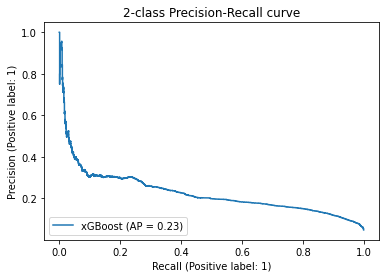

In [18]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_val[features], tor_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Train on balanced dataset

In [19]:
outage = tor_tt[tor_tt['power_outage']==True]
no_outage = tor_tt[tor_tt['power_outage']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [65]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    seed=42)

parameters = {
    'max_depth': range (8, 16,  1),
    'n_estimators': range(300, 350, 10),
    'learning_rate': [0.01]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01], 'max_depth': range(8, 16),
                         'n_estimators': range(300, 350, 10)},
             scoring='f1', verbose=True)

In [60]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 8, 300): 0.435617813613485,
 (0.01, 8, 310): 0.4398557325075424,
 (0.01, 8, 320): 0.4458084720930696,
 (0.01, 8, 330): 0.449727304057978,
 (0.01, 8, 340): 0.4531378880374695,
 (0.01, 9, 300): 0.5024558040876385,
 (0.01, 9, 310): 0.5040329786282072,
 (0.01, 9, 320): 0.5069227749672148,
 (0.01, 9, 330): 0.5090185601607351,
 (0.01, 9, 340): 0.5119163964138421,
 (0.01, 10, 300): 0.5399259869057087,
 (0.01, 10, 310): 0.5426319727789751,
 (0.01, 10, 320): 0.5443796291436305,
 (0.01, 10, 330): 0.5466810440042035,
 (0.01, 10, 340): 0.5479233557623454,
 (0.01, 11, 300): 0.5678703765505253,
 (0.01, 11, 310): 0.5680072870652977,
 (0.01, 11, 320): 0.5689040287434841,
 (0.01, 11, 330): 0.5691183197948773,
 (0.01, 11, 340): 0.5694010324779397,
 (0.01, 12, 300): 0.5818457678079545,
 (0.01, 12, 310): 0.5826454347876142,
 (0.01, 12, 320): 0.5835539572154123,
 (0.01, 12, 330): 0.5844152813266426,
 (0.01, 12, 340): 0.5855954573466997,
 (0.01, 13, 300): 0.5875395040192106,
 (0.01, 13, 310): 0.5882

In [61]:
#best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=340, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic', learning_rate=0.01, max_depth=15, n_estimators=340)
best_model.fit(balanced[features], balanced['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=340, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
preds = best_model.predict(tor_val[features])
prec = precision_score(preds, tor_val['power_outage'])
recall = recall_score(preds, tor_val['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.8395200599925009
recall:  0.15410558193956914


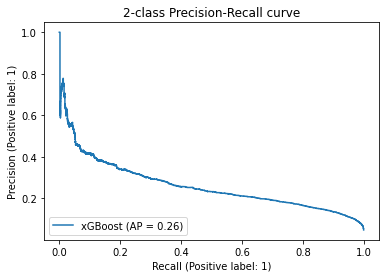

In [23]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_val[features], tor_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

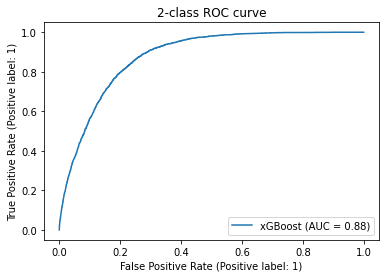

In [24]:
from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_estimator(
    best_model, tor_val[features], tor_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class ROC curve")

# Last attemp: Using only a subset of predictors 

In [26]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max', 'Month']

In [31]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    seed=42)

parameters = {
    'max_depth': range (10, 20,  1),
    'n_estimators': range(240, 400, 40),
    'learning_rate': [0.01, 0.03]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    verbose=True)
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.03],
                         'max_depth': range(10, 20),
                         'n_estimators': range(240, 400, 40)},
             scoring='f1', verbose=True)

In [32]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.01, 10, 240): 0.8031410731376172,
 (0.01, 10, 280): 0.8036149278339672,
 (0.01, 10, 320): 0.8042913119034287,
 (0.01, 10, 360): 0.8041545050561014,
 (0.01, 11, 240): 0.8069682626278245,
 (0.01, 11, 280): 0.8082713556218947,
 (0.01, 11, 320): 0.8082377457663261,
 (0.01, 11, 360): 0.8091353269235999,
 (0.01, 12, 240): 0.8081969134744031,
 (0.01, 12, 280): 0.8100739853036212,
 (0.01, 12, 320): 0.8100150712336329,
 (0.01, 12, 360): 0.8093145781128916,
 (0.01, 13, 240): 0.8094114055747859,
 (0.01, 13, 280): 0.8096481387547719,
 (0.01, 13, 320): 0.8091332495229582,
 (0.01, 13, 360): 0.8097661485284442,
 (0.01, 14, 240): 0.8100294358068382,
 (0.01, 14, 280): 0.8098657801277656,
 (0.01, 14, 320): 0.8114557773456014,
 (0.01, 14, 360): 0.8109612250711375,
 (0.01, 15, 240): 0.8087595024437911,
 (0.01, 15, 280): 0.8086127646743175,
 (0.01, 15, 320): 0.8089555598786975,
 (0.01, 15, 360): 0.8088563696128134,
 (0.01, 16, 240): 0.8091536199124931,
 (0.01, 16, 280): 0.8084525870519469,
 (0.01, 16, 

In [33]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 320}

In [34]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic', learning_rate=0.01, max_depth=14, n_estimators=320)
best_model.fit(balanced[features], balanced['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=320, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
preds = best_model.predict(tor_val[features])
prec = precision_score(preds, tor_val['power_outage'])
recall = recall_score(preds, tor_val['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.8515185601799775
recall:  0.15431134062648638


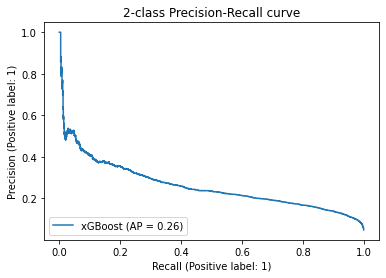

In [36]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, tor_val[features], tor_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

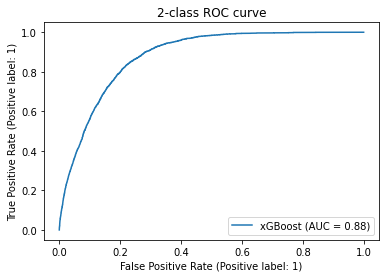

In [37]:
from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_estimator(
    best_model, tor_val[features], tor_val['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class ROC curve")

In [39]:
best_model.get_booster().get_score(importance_type='gain')

{'LAT_mean': 4.38847017288208,
 'LON_mean': 5.330265998840332,
 'AVGDV_max': 1.5012129545211792,
 'LLDV_max': 1.4860434532165527,
 'MXDV_max': 1.9206308126449585,
 'Month': 9.31014347076416}